In [1]:
# IMPORTS FOR ALL THE PROJECT
import numpy as np
import os
import requests
from numpy.random import default_rng
import matplotlib
import matplotlib.pyplot as plt
import tarfile
from six.moves import urllib
import pandas as pd



## Data imports

In [2]:
# PATH TO THE FILES

urls= ['https://raw.githubusercontent.com/Plexiglace-EL/projet-IA/main/general_data.csv',
       'https://raw.githubusercontent.com/Plexiglace-EL/projet-IA/main/manager_survey_data.csv',
       'https://raw.githubusercontent.com/Plexiglace-EL/projet-IA/main/employee_survey_data.csv',
       'https://raw.githubusercontent.com/Plexiglace-EL/projet-IA/main/in_time.csv',
       'https://raw.githubusercontent.com/Plexiglace-EL/projet-IA/main/out_time.csv']

paths = ['./datasets/general_data.csv',
         './datasets/manager_survey_data.csv',
         './datasets/employee_survey_data.csv',
         './datasets/in_time.csv',
         './datasets/out_time.csv']

In [3]:

def fetch_datas(url, path):
    localfile, header = urllib.request.urlretrieve(url, path)
    print(localfile)
    return localfile

def extractZip(path):
    with tarfile.open(path) as tf:
        tf.extractall('./datasets')


In [4]:
def import_all_files():
    print('==='*4, "BEGIN", '==='*4)


    if not os.path.exists('./datasets/'):
        print('==='*4, "CREATING \"./datasets/\" DIRECTORY", '==='*4)
        os.mkdir('./datasets')

    for i, url in enumerate(urls):
        fetch_datas(urls[i], paths[i])

    print('==='*4, "FINISHED", '==='*4)

## Data loading in dataframes

In [5]:
def load_datas(path):
    datas = pd.read_csv(path)
    return datas

In [6]:
import_all_files()

============ BEGIN ============
./datasets/general_data.csv
./datasets/manager_survey_data.csv
./datasets/employee_survey_data.csv
./datasets/in_time.csv
./datasets/out_time.csv
============ FINISHED ============


In [7]:
X = load_datas(paths[0])
y = X.loc[:, ['Attrition']]
X = X.drop(columns=['EmployeeID', 'EmployeeCount', 'Attrition', 'Over18', 'StandardHours'], axis=1)
manager_survey = load_datas(paths[1])
employee_survey = load_datas(paths[2])
in_time = load_datas(paths[3])
out_time = load_datas(paths[4])

## Data Normalisation and Standardisation

In [8]:
def converting_string_to_dates(in_time, out_time):
    # RENAMING THE UNNAMED COLUMN (ID_EMPLOYEE) FOR IT TO BE USEABLE MORE EASILY IN THE FUTURE

    in_time = in_time.rename(columns={'Unnamed: 0': 'id_employee'})
    out_time = out_time.rename(columns={'Unnamed: 0': 'id_employee'})


    # WE CAN USE THE COLUMNS OF ONLY ONE FILE BECAUSE THEY ARE BOTH THE SAME AND CONTAINS THE SAME HEADERS NAME
    # IT HAS BEEN VERIFIED USING LIST COMPARISON AND UNIQUE() CONDITION TO FILTER AND WE END WITH A TOTAL OF 262 COLUMNS
    cols = in_time.columns


    # CONVERTING THE DATES TO REAL PANDAS DATES OBJECT
    for i in cols:
        if i != 'id_employee':
            in_time[i] = pd.to_datetime(in_time[i])
            out_time[i] = pd.to_datetime(out_time[i])

    return in_time, out_time

In [9]:
#converting in and out time dataframes into pandas date obj
in_time, out_time = converting_string_to_dates(in_time, out_time)

In [10]:
# using the converted dates to calculate the working time of each employee
def calculate_working_time():

    working_time = in_time.copy()
    for i in working_time:
        if i != 'id_employee':
            working_time[i] = out_time[i] - working_time[i]
            
    return working_time

Adding working data to General Dataframe

In [11]:
working_time = calculate_working_time()

Adding Employee and Manager Survey to DataFrame

In [12]:


def import_columns(X):
    print('==='*5)
    print('IMPORTING COLUMNS FROM OTHER DATAFRAMES TO MAIN DATAFRAME')
    print('==='*5, '\n')

    # Adding the calculated mean value of the working time of each employee to the main dataframe
    mean_time = working_time.copy()
    mean_time = mean_time.drop('id_employee', axis=1)
    X['mean-timework'] = mean_time.mean(axis = 1)
    X['mean-timework'] = X['mean-timework'].dt.total_seconds() / 3600
    X['mean-timework'] = round(X['mean-timework'], 2)
    # Adding the rest of the datas (from the survey)
    X['EnvironmentSatisfaction'] = employee_survey['EnvironmentSatisfaction']
    X['JobSatisfaction'] = employee_survey['JobSatisfaction']
    X['WorkLifeBalance'] = employee_survey['WorkLifeBalance']
    X['JobInvolvement'] = manager_survey['JobInvolvement']
    X['PerformanceRating'] = manager_survey['PerformanceRating']

    # Reformating the column of the existing general DF for comprehension
    X = X.reindex(columns=['EmployeeID','Age','Attrition','BusinessTravel','Department','DistanceFromHome','Education','EducationField','EmployeeCount','Gender','JobLevel','JobRole','MaritalStatus','MonthlyIncome','NumCompaniesWorked','Over18','PercentSalaryHike','StandardHours','StockOptionLevel','TotalWorkingYears','TrainingTimesLastYear','YearsAtCompany','YearsSinceLastPromotion','YearsWithCurrManager','mean-timework','EnvironmentSatisfaction','JobSatisfaction','WorkLifeBalance','JobInvolvement','PerformanceRating'])


Removing error values and replace them with their median

In [13]:
def fill_nan(X):
    print('==='*5)
    print('REPLACING NULL VALUES WITH MEDIAN OR MEAN VALUES OF THE CORREPONDING EMPLOYEE')
    print('==='*5, '\n')

    X["NumCompaniesWorked"] = X["NumCompaniesWorked"].fillna(X["NumCompaniesWorked"].median())
    X["TotalWorkingYears"] = X["TotalWorkingYears"].fillna(X["TotalWorkingYears"].median())

    environmentSatisMean = X["EnvironmentSatisfaction"].mean(axis = 0)
    jobSatisMean = X["JobSatisfaction"].mean(axis=0)
    worklifemean = X["WorkLifeBalance"].mean(axis=0)

    for a, value in X['EnvironmentSatisfaction'].isnull().iteritems():
        if value:
            X['EnvironmentSatisfaction'][a] = environmentSatisMean

    for a, value in X["JobSatisfaction"].isnull().iteritems():
        if value:
            X['JobSatisfaction'][a] = jobSatisMean

    for a, value in X["WorkLifeBalance"].isnull().iteritems():
        if value:
            X['WorkLifeBalance'][a] = worklifemean

Separing numerics data from categorical data for normalisation purpose

In [14]:
def get_attribs(X):


    num_attribs = list(X.select_dtypes(include=[np.number]))
    cat_attribs = list(X.select_dtypes(exclude=[np.number]))

    return num_attribs, cat_attribs

In [15]:
# Encoder to convert the text data to actual values

from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()

    
def personnal_encoder(df, col):
    df[col] = label_enc.fit_transform(df[col])
    return df

def label_encoding(df):
    num_attribs, cat_attribs = get_attribs(df)
    print('==='*5)
    print('ENCODING THE FOLLOWING ATTRIBUTES : \n',cat_attribs)
    print('==='*5, '\n')
    for i in cat_attribs:
        df = personnal_encoder(df, i)

In [16]:
from sklearn.preprocessing import StandardScaler
def standard_scaler(X):
    sts = StandardScaler()
    num_attribs, cat_attribs = get_attribs(X)
    
    print('==='*5)
    print('SCALING THE FOLLOWING ATTRIBUTES : \n', num_attribs)
    print('==='*5, '\n')
    X_num = X.loc[:, num_attribs]
    sts.fit(X_num)
    X_num = pd.DataFrame(sts.transform(X_num), columns=num_attribs)
    for i in X_num.columns:
        X[i] = X_num[i]

## Preparation Pipeline

Pipeline to normalize and standardize the datas depending on if it's a categorical value or a numeric value

In [17]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler



prep_pipeline = Pipeline(
    [
        ('import', FunctionTransformer(import_columns(X))),
        ('fill_nan', FunctionTransformer(fill_nan(X))),
        ('prep', FunctionTransformer(label_encoding(X))),
        ('prepy', FunctionTransformer(label_encoding(y))),
        ('scaler', FunctionTransformer(standard_scaler(X)))
    ]
)
prep_pipeline.fit(X, y)

IMPORTING COLUMNS FROM OTHER DATAFRAMES TO MAIN DATAFRAME

REPLACING NULL VALUES WITH MEDIAN OR MEAN VALUES OF THE CORREPONDING EMPLOYEE

ENCODING THE FOLLOWING ATTRIBUTES : 
 ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']

ENCODING THE FOLLOWING ATTRIBUTES : 
 ['Attrition']

SCALING THE FOLLOWING ATTRIBUTES : 
 ['Age', 'BusinessTravel', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'Gender', 'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'mean-timework', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating']



/var/folders/h0/cy1ln8px4bd1n1wrb07kgdqr0000gn/T/ipykernel_58386/3267696405.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['EnvironmentSatisfaction'][a] = environmentSatisMean
/var/folders/h0/cy1ln8px4bd1n1wrb07kgdqr0000gn/T/ipykernel_58386/3267696405.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['JobSatisfaction'][a] = jobSatisMean
/var/folders/h0/cy1ln8px4bd1n1wrb07kgdqr0000gn/T/ipykernel_58386/3267696405.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Pipeline(steps=[('import', FunctionTransformer()),
                ('fill_nan', FunctionTransformer()),
                ('prep', FunctionTransformer()),
                ('prepy', FunctionTransformer()),
                ('scaler', FunctionTransformer())])

Model Pipeline, this pipeline contains a model that will be used to predict the results using the data normalized before

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score




X_train, X_Test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


pipeline = Pipeline(
    [
        ('tree', DecisionTreeClassifier())   
    ]
)
pipeline.fit(X_train, y_train)
score = pipeline.score(X_Test, y_test)
predict = pipeline.predict(X_Test)
trainaccuracy = accuracy_score(y_test,predict)
print('accuracy_score on test dataset : ', trainaccuracy, "score pipeline : ",score)

accuracy_score on test dataset :  0.9829931972789115 score pipeline :  0.9829931972789115


Working with the data to create correlation matrixs

In [19]:
X_corr = X.loc[:, :]
X_corr['Attrition'] = y.copy()
X_corr = personnal_encoder(X_corr, 'Attrition')

In [20]:
size = 26
correlation  = X_corr.corr(method='pearson')
small = list(correlation.nsmallest(size, 'Attrition').index)
neg_corr = X_corr.loc[:, small]


Correlation Matrixs

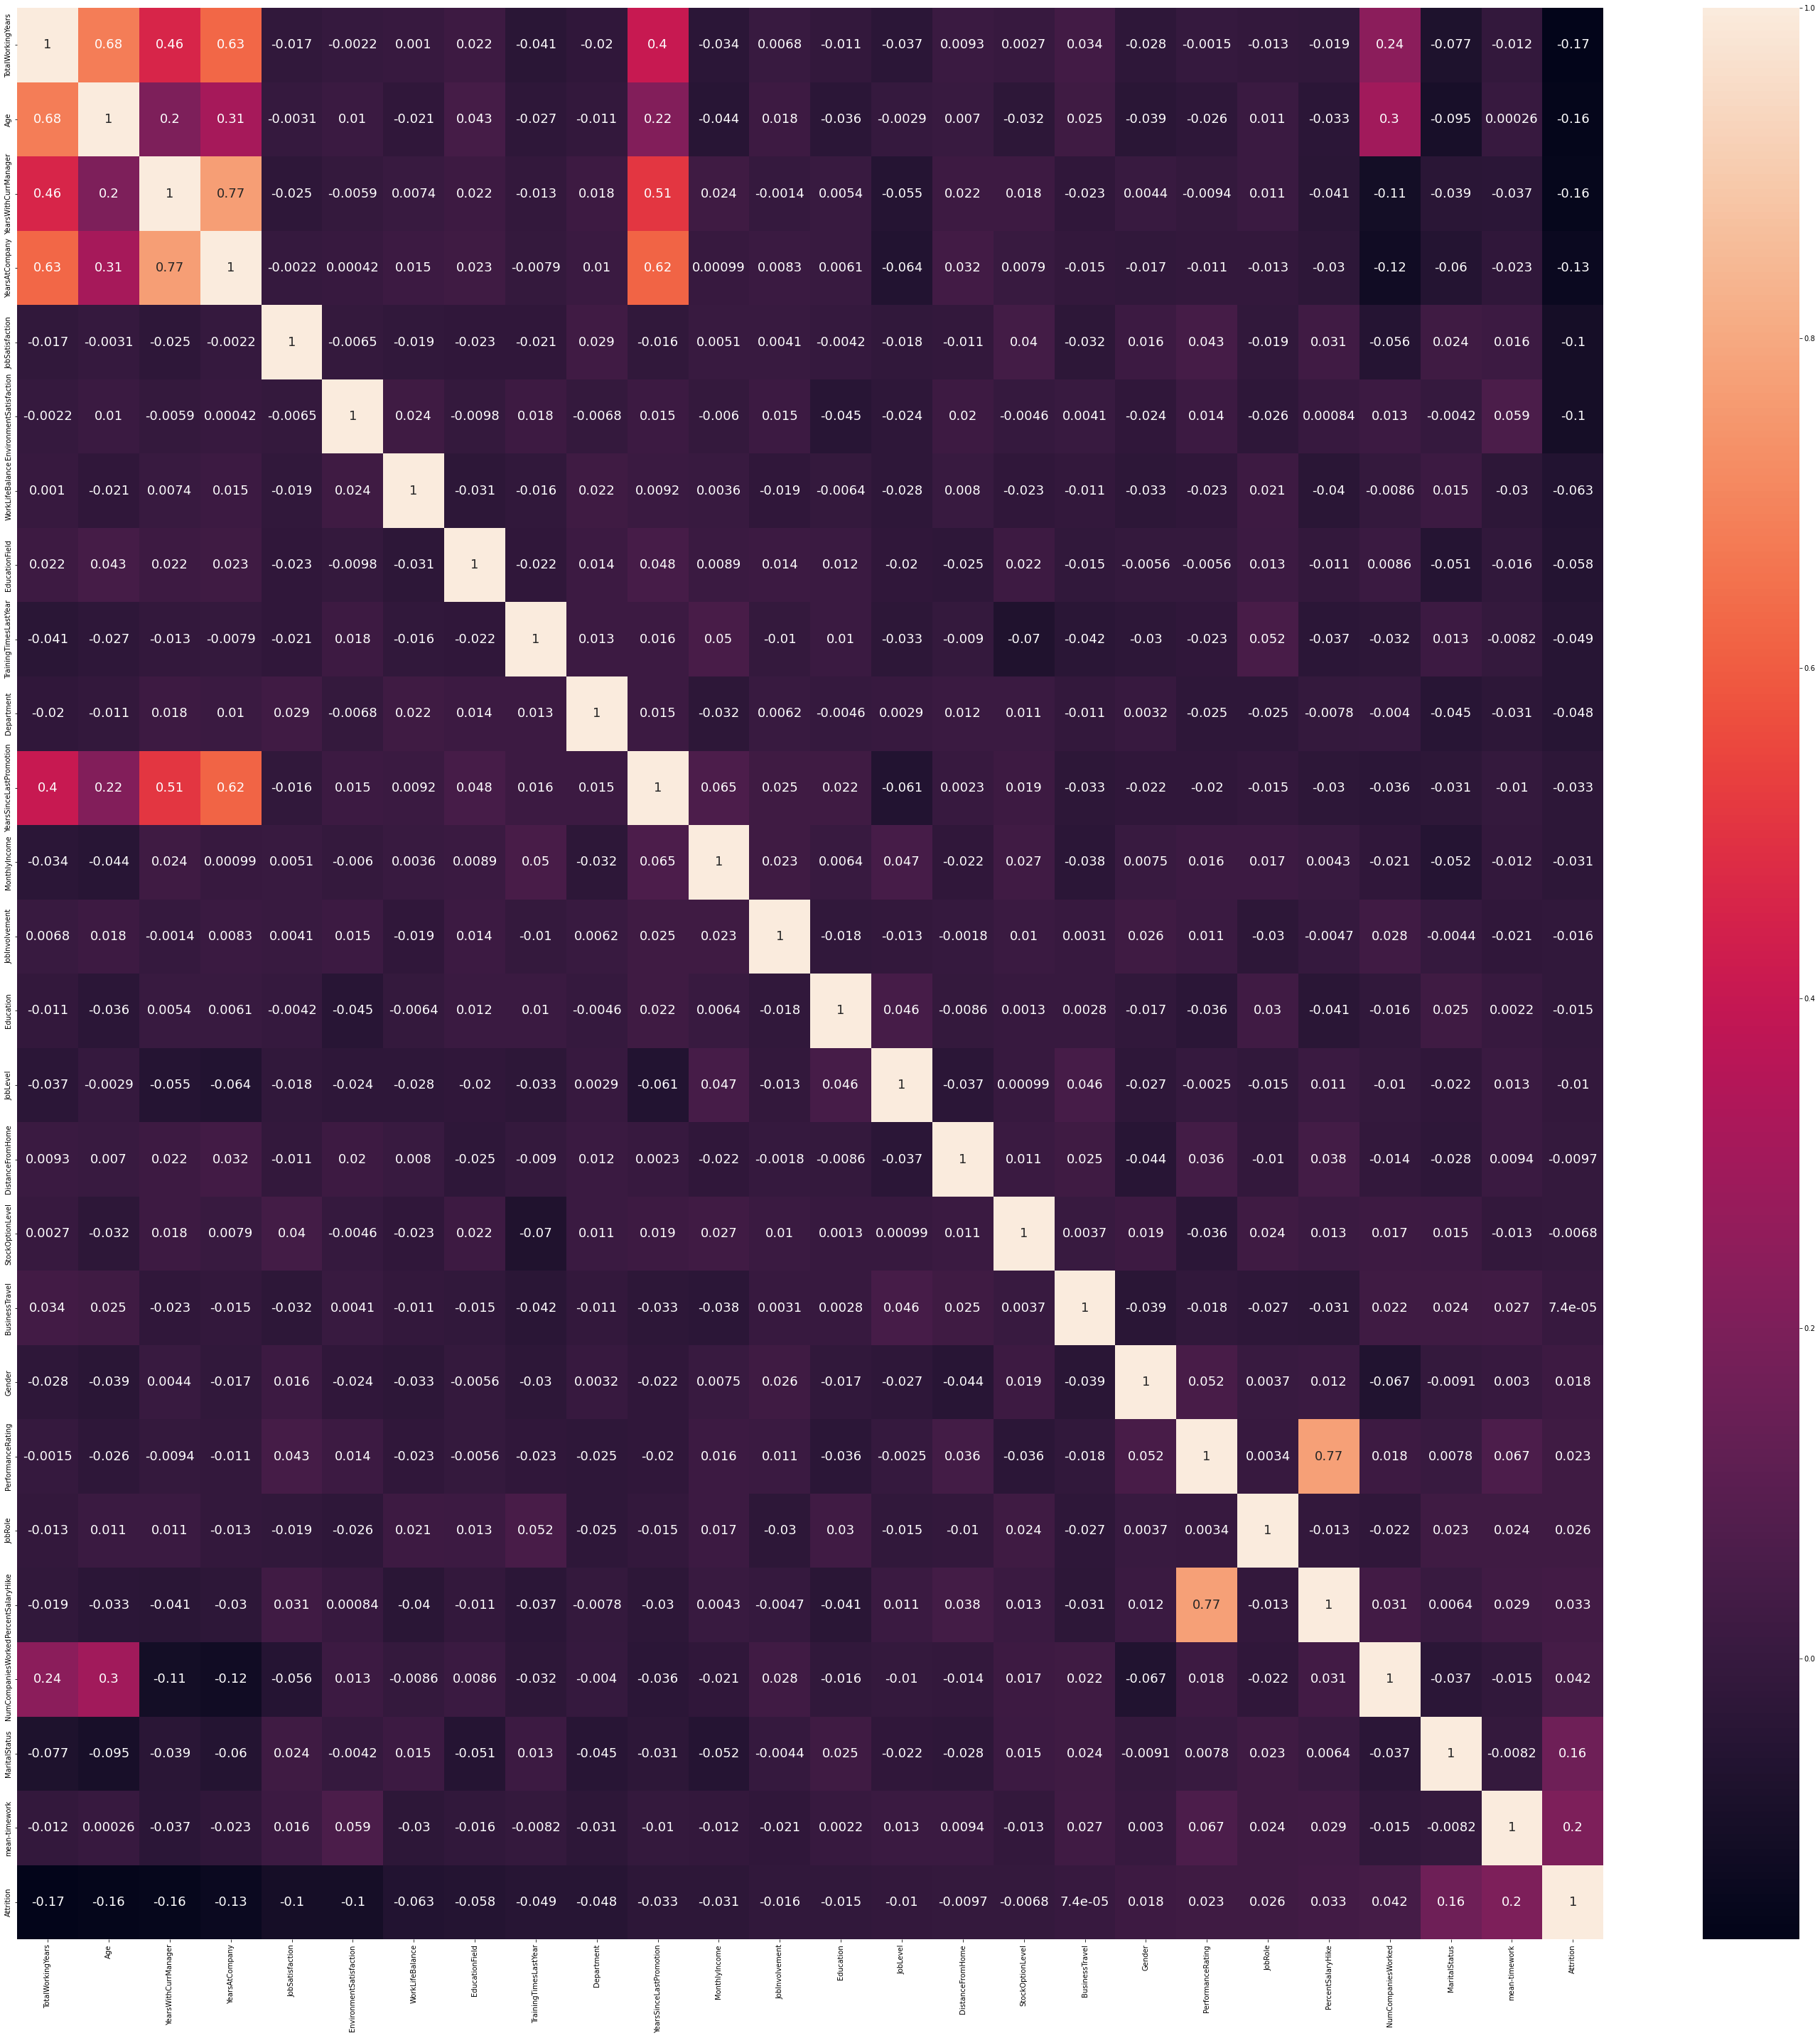

In [21]:
import seaborn as sns
plt.figure(figsize = (50,50))
sns.heatmap(neg_corr.corr(method='pearson'), annot= True, annot_kws={'size': 18})
plt.show()

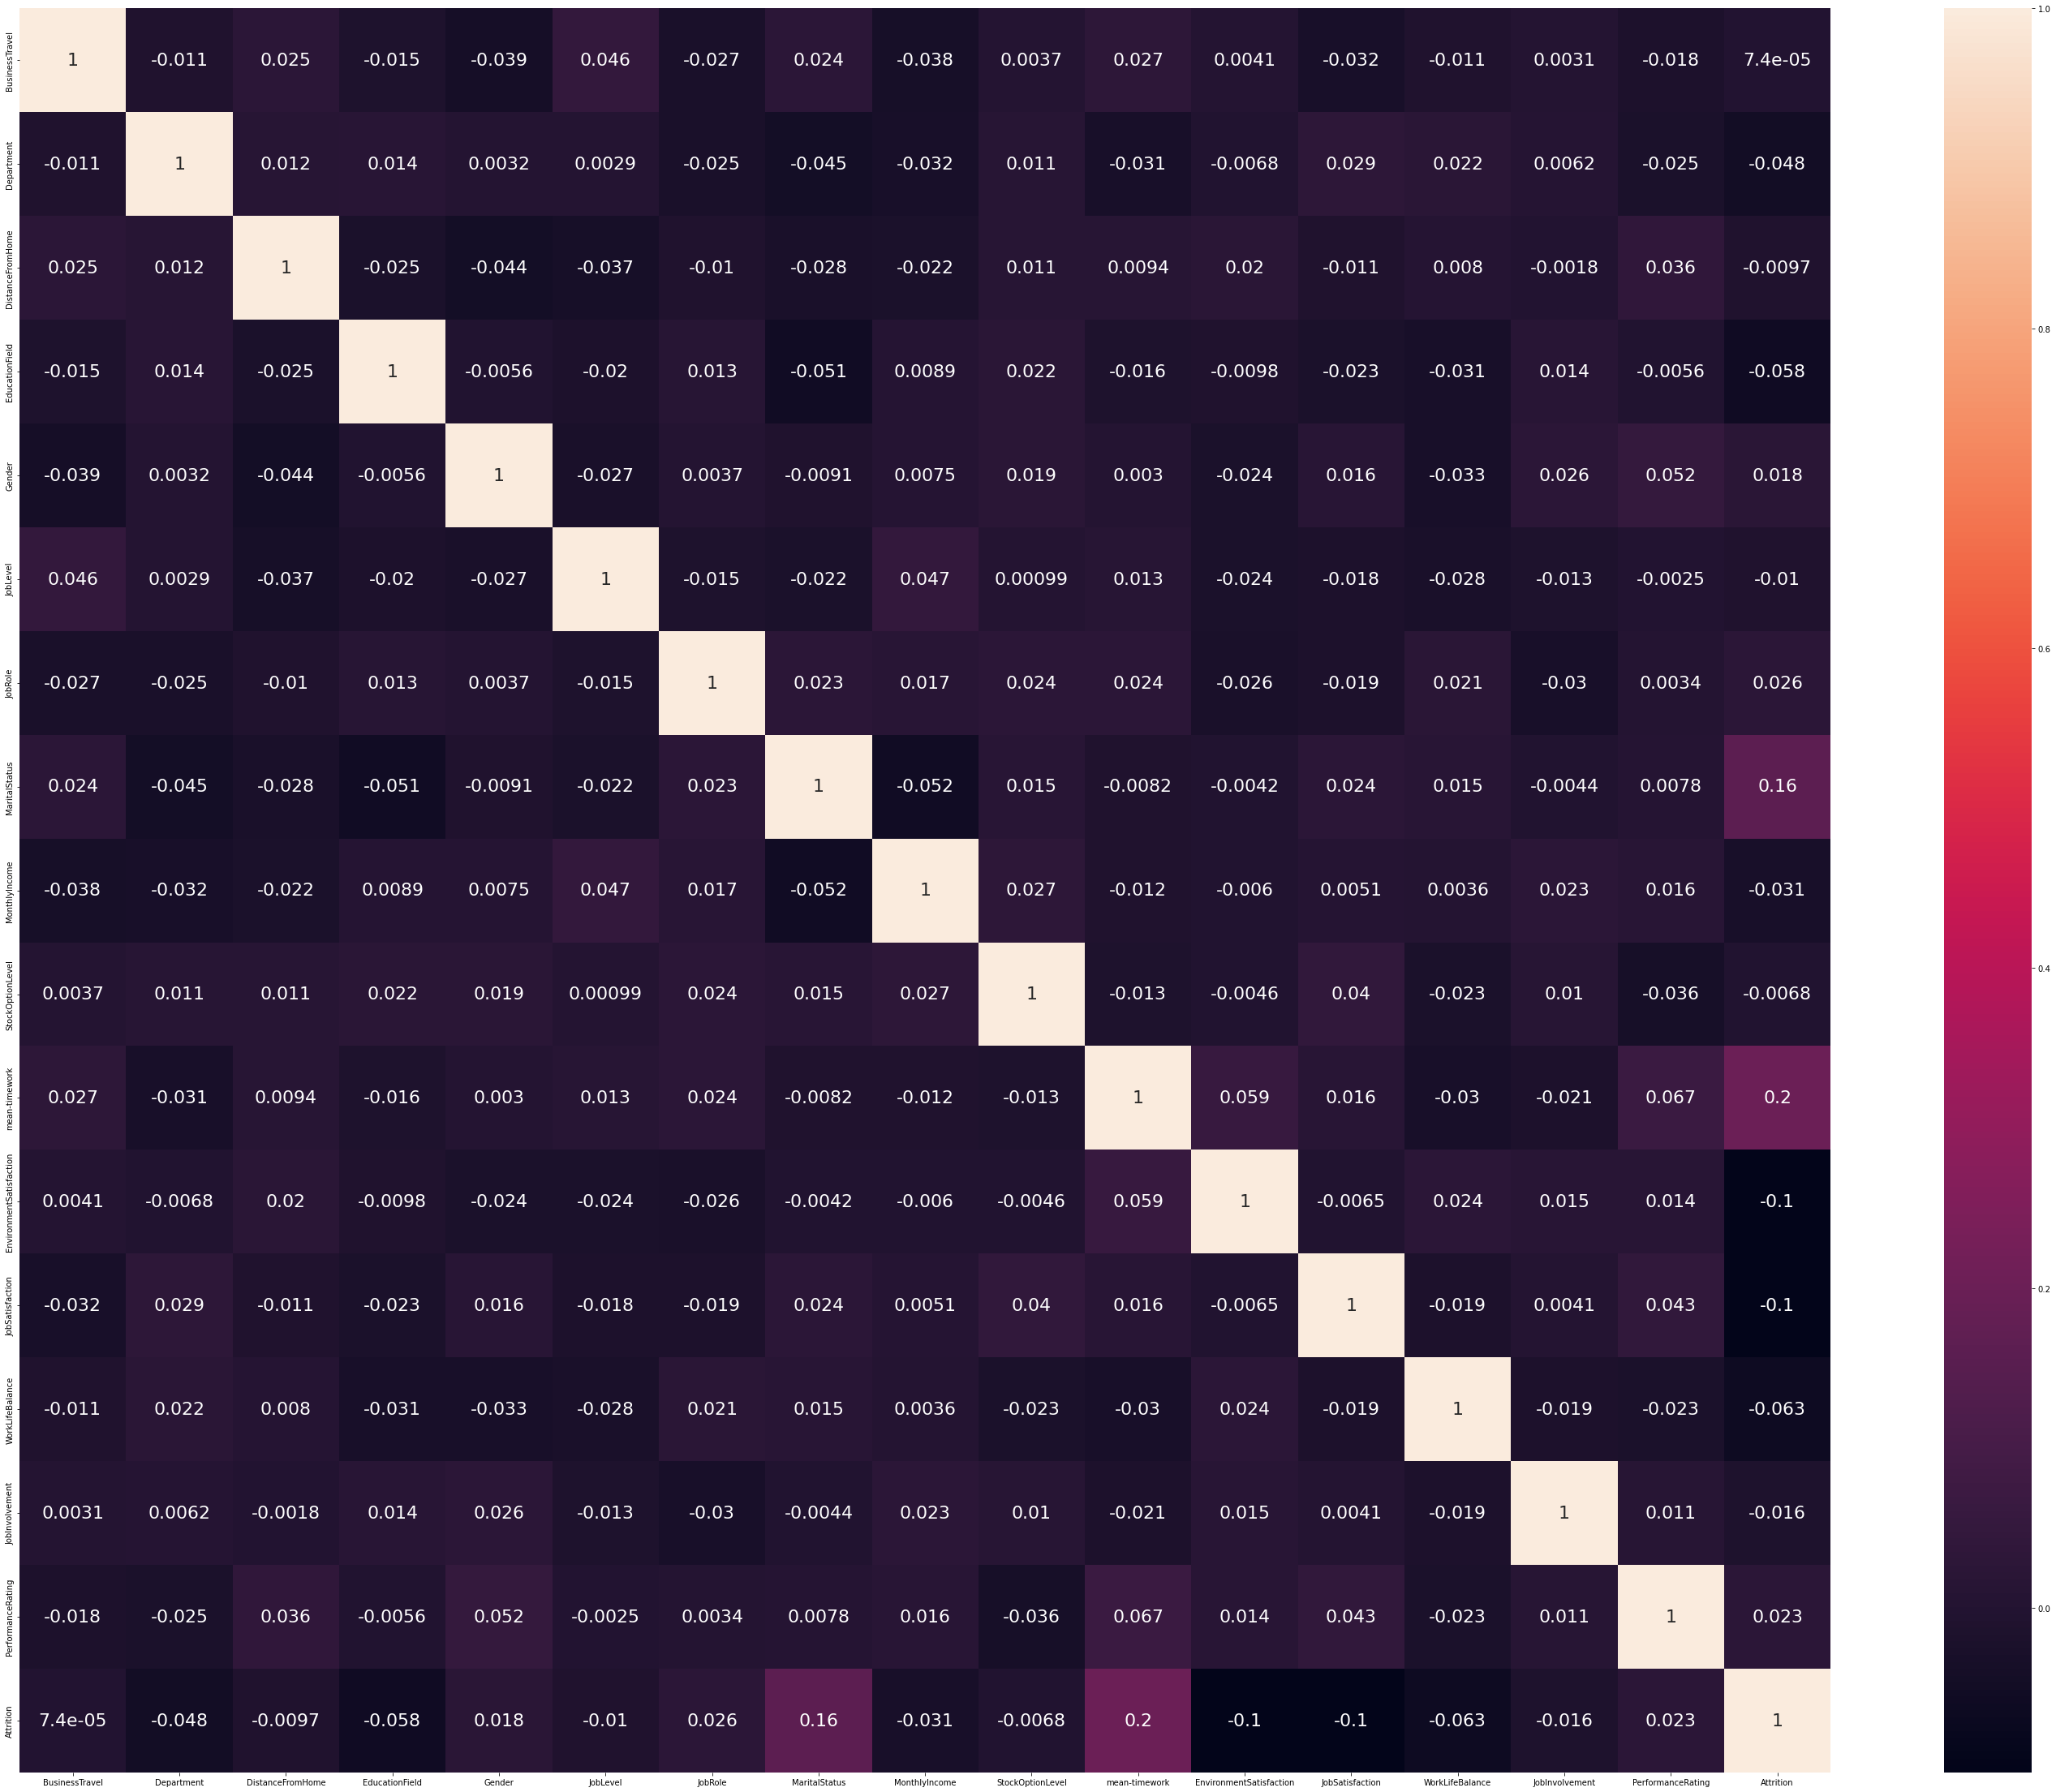

In [22]:
import seaborn as sns
X_corr_2 = X.loc[:, :]

X_corr_2 = X_corr_2.drop(columns=['Age', 'Education', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager'])
plt.figure(figsize=(50, 40))
correlation = X_corr_2.corr(method='pearson')
correlation.describe()
sns.heatmap(correlation, annot=True, annot_kws={'size': 22})
plt.show()



### Score earned with a Decision Tree Classifier

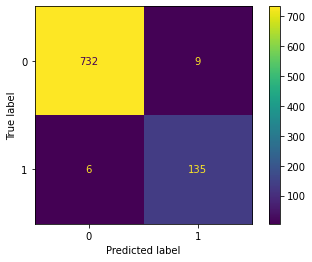

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

confusion = confusion_matrix(y_test, predict)
cm_display = ConfusionMatrixDisplay(confusion).plot()



We will calculate all of every metrics score manually

In [24]:
precision = confusion[1][1] / (confusion[1][1] + confusion[0][1])
print ("Precision :",precision)

Precision : 0.9375


In [25]:
recall = confusion[1][1] / (confusion[1][1] + confusion[1][0])
print ("Recall : ", recall)

Recall :  0.9574468085106383


In [26]:
from sklearn.metrics import f1_score
print("F1 Score : ", f1_score(y_test,predict))

F1 Score :  0.9473684210526315


In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       741
           1       0.94      0.96      0.95       141

    accuracy                           0.98       882
   macro avg       0.96      0.97      0.97       882
weighted avg       0.98      0.98      0.98       882



ROC and AUC infos

Area under the curve score :  0.9726505297613921


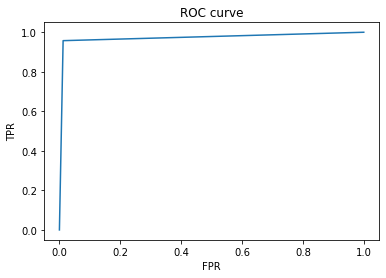

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score
print ("Area under the curve score : "  ,roc_auc_score(y_test,predict))
fpr, tpr, _ = roc_curve(y_test, predict)
plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

## Model : Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression


pipeline = Pipeline(
    [
        ('logReg', LogisticRegression())   
    ]
)
pipeline.fit(X_train, y_train)
score = pipeline.score(X_Test, y_test)
predict = pipeline.predict(X_Test)
trainaccuracy = accuracy_score(y_test,predict)
print('accuracy_score on test dataset : ', trainaccuracy, "score pipeline : ",score)

accuracy_score on test dataset :  0.8537414965986394 score pipeline :  0.8537414965986394


/Users/gauthierclet/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


### Score earned with a Logistic Regression

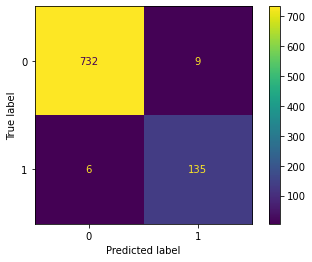

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

confusion2 = confusion_matrix(y_test, predict)
cm_display = ConfusionMatrixDisplay(confusion).plot()


We will calculate all of every metrics score manually

In [31]:
precision = confusion2[1][1] / (confusion2[1][1] + confusion2[0][1])
print ("Precision :",precision)

Precision : 0.603448275862069


In [32]:
recall = confusion2[1][1] / (confusion2[1][1] + confusion2[1][0])
print ("Recall : ", recall)

Recall :  0.24822695035460993


In [33]:
from sklearn.metrics import f1_score
print("F1 Score : ", f1_score(y_test,predict))

F1 Score :  0.3517587939698492


In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       741
           1       0.60      0.25      0.35       141

    accuracy                           0.85       882
   macro avg       0.74      0.61      0.63       882
weighted avg       0.83      0.85      0.83       882



Area under the curve score :  0.6085939070261579


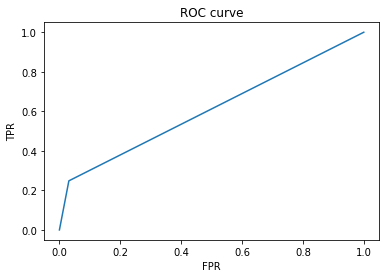

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score
print ("Area under the curve score : "  ,roc_auc_score(y_test,predict))
fpr, tpr, _ = roc_curve(y_test, predict)
plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

## Model : K-NN Neighbors

In [36]:
from sklearn.neighbors import KNeighborsClassifier



pipeline = Pipeline(
    [
        ('knn', KNeighborsClassifier(n_neighbors = 2))   
    ]
)

pipeline.fit(X_train, y_train)
score = pipeline.score(X_Test, y_test)
predict = pipeline.predict(X_Test)
trainaccuracy = accuracy_score(y_test,predict)
print('accuracy_score on test dataset : ', trainaccuracy, "score pipeline : ",score)

/Users/gauthierclet/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


accuracy_score on test dataset :  0.9501133786848073 score pipeline :  0.9501133786848073


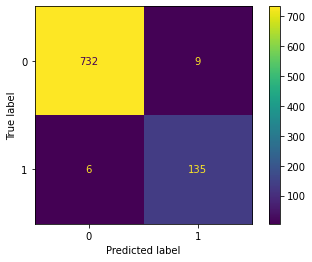

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

confusion3 = confusion_matrix(y_test, predict)
cm_display = ConfusionMatrixDisplay(confusion).plot()



We will calculate all of every metrics score manually

In [38]:
precision = confusion3[1][1] / (confusion3[1][1] + confusion3[0][1])
print ("Precision :",precision)

Precision : 1.0


In [39]:
recall = confusion3[1][1] / (confusion3[1][1] + confusion3[1][0])
print ("Recall : ", recall)

Recall :  0.6879432624113475


In [40]:
from sklearn.metrics import f1_score
print("F1 Score : ", f1_score(y_test,predict))

F1 Score :  0.8151260504201681


In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       741
           1       1.00      0.69      0.82       141

    accuracy                           0.95       882
   macro avg       0.97      0.84      0.89       882
weighted avg       0.95      0.95      0.95       882



Area under the curve score :  0.8439716312056738


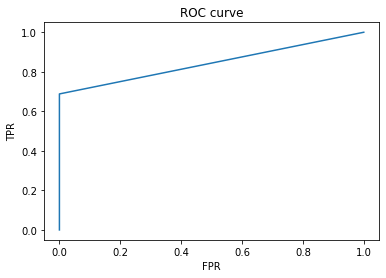

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score
print ("Area under the curve score : "  ,roc_auc_score(y_test,predict))
fpr, tpr, _ = roc_curve(y_test, predict)
plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()